In [275]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import normalize
import xgboost as xgb
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning) # on supprime les warnings génants pour la lisibilité

### On load les 4 datasets différents

In [276]:
dataset_v1 = pd.read_pickle('dataset.pkl')
Y_v1 = dataset_v1["Y"]
dataset_v1 = dataset_v1.drop(columns=['Y'])
dataset_v2 = pd.read_pickle('datasetv2.pkl')
Y_v2 = dataset_v2["Y"]
dataset_v2 = dataset_v2.drop(columns=['Y'])
dataset_v3 = pd.read_pickle('datasetv3.pkl')
Y_v3 = dataset_v3["Y"]
dataset_v3 = dataset_v3.drop(columns=['Y'])
dataset_v4 = pd.read_pickle('datasetv4_transformed.pkl')

Y = [Y_v1, Y_v2, Y_v3, Y_v3]


### Comparaison des features des datasets

##### Nombre de features

Text(4, 90, '88')

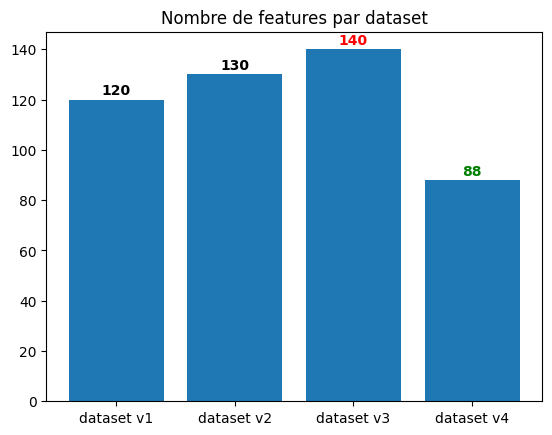

In [277]:
# create a bar chart of the number of features in each dataset
nb_features_v1 = dataset_v1.shape[1]
nb_features_v2 = dataset_v2.shape[1]
nb_features_v3 = dataset_v3.shape[1]
nb_features_v4 = dataset_v4.shape[1]

plt.bar([1,2,3,4],[nb_features_v1,nb_features_v2,nb_features_v3,nb_features_v4])
plt.xticks([1,2,3,4],['dataset v1','dataset v2','dataset v3','dataset v4'])
plt.title('Nombre de features par dataset')


plt.text(x=1,y=nb_features_v1+2,s=nb_features_v1,ha='center', fontweight='demibold',color='black')
plt.text(x=2,y=nb_features_v2+2,s=nb_features_v2,ha='center', fontweight='demibold',color='black')
plt.text(x=3,y=nb_features_v3+2,s=nb_features_v3,ha='center', fontweight='demibold',color='red')
plt.text(x=4,y=nb_features_v4+2,s=nb_features_v4,ha='center', fontweight='demibold',color='green')


##### Features en communs

<AxesSubplot: >

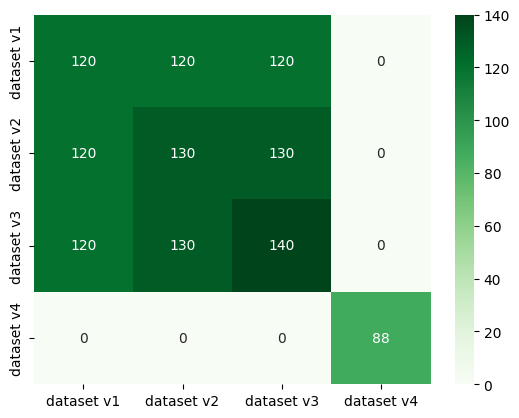

In [278]:
columns_v1 = dataset_v1.columns
columns_v2 = dataset_v2.columns
columns_v3 = dataset_v3.columns
columns_v4 = dataset_v4.columns

table = pd.DataFrame(columns=['dataset v1','dataset v2','dataset v3','dataset v4'])
table.loc['dataset v1'] = [len(columns_v1),len(columns_v1.intersection(columns_v2)),len(columns_v1.intersection(columns_v3)),len(columns_v1.intersection(columns_v4))]
table.loc['dataset v2'] = [len(columns_v2.intersection(columns_v1)),len(columns_v2),len(columns_v2.intersection(columns_v3)),len(columns_v2.intersection(columns_v4))]
table.loc['dataset v3'] = [len(columns_v3.intersection(columns_v1)),len(columns_v3.intersection(columns_v2)),len(columns_v3),len(columns_v3.intersection(columns_v4))]
table.loc['dataset v4'] = [len(columns_v4.intersection(columns_v1)),len(columns_v4.intersection(columns_v2)),len(columns_v4.intersection(columns_v3)),len(columns_v4)]


sns.heatmap(table,annot=True,fmt='d',cmap='Greens')



> le 4ème dataset partage ne partage aucune features avec les autres dataset, celui-ci ayant été totalement remanié

> Quelles sont les 10 features rajoutées au dataset v1 puis au dataset v2 ?

In [279]:
print(columns_v1.symmetric_difference(columns_v2))
print(columns_v1.symmetric_difference(columns_v3))
print(columns_v2.symmetric_difference(columns_v3))

Index(['ADC0_VS', 'ADC1_VS', 'JGL0_VS', 'JGL1_VS', 'MID0_VS', 'MID1_VS',
       'SUP0_VS', 'SUP1_VS', 'TOP0_VS', 'TOP1_VS'],
      dtype='object')
Index(['ADC0_MAS', 'ADC0_VS', 'ADC1_MAS', 'ADC1_VS', 'JGL0_MAS', 'JGL0_VS',
       'JGL1_MAS', 'JGL1_VS', 'MID0_MAS', 'MID0_VS', 'MID1_MAS', 'MID1_VS',
       'SUP0_MAS', 'SUP0_VS', 'SUP1_MAS', 'SUP1_VS', 'TOP0_MAS', 'TOP0_VS',
       'TOP1_MAS', 'TOP1_VS'],
      dtype='object')
Index(['ADC0_MAS', 'ADC1_MAS', 'JGL0_MAS', 'JGL1_MAS', 'MID0_MAS', 'MID1_MAS',
       'SUP0_MAS', 'SUP1_MAS', 'TOP0_MAS', 'TOP1_MAS'],
      dtype='object')


> Les features en VS (matchup :winrate moyen du perso par rapport à toute la team adverse:) ont été rajoutés pour la v2, les MAS (masteries :points de maîtrise sur le perso) pour la v3

##### Comparaison la feature importance de différentes features en fonction du dataset utilisé

> FE rapide pour avoir toutes les colonnes dans le bon type, et s'occuper des colonnes qui sont des listes de valeurs (KDA et KDAG) pour les datasets v1, v2 et v3

In [280]:
datasets = [dataset_v1,dataset_v2,dataset_v3,dataset_v4]

In [281]:
datasets_post_FE = []

for dataset in datasets[:3]:

    #suppression des KDA car bcp de 0
    roles = ["TOP","JGL","MID","ADC","SUP"]
    colomnes = []
    for i in [0,1]:
        for role in roles :
            colomnes.append(f"{role}{i}_KDA")
    # print(colomnes)
    dataset = dataset.drop(columns = colomnes)

    #----------------------------------------------

    # suppression des listes pour le KDAG par transformation en plusieurs colomnes
    colomnes_KDAG=[]
    for colomne in colomnes:
        colomnes_KDAG.append(colomne + "G")

    for colomne in colomnes_KDAG:
        nom = colomne[:-4]
        data2 = pd.DataFrame(dataset[f"{colomne}"].to_list(),dataset.index,columns=[f"{nom}K",f"{nom}D",f"{nom}A",])
        dataset[f'{nom}KDA_Ratio'] = (data2[f'{nom}K'] + data2[f'{nom}A']) / (data2[f'{nom}D']+1)
        dataset = dataset.drop(columns = colomne)

    #----------------------------------------------

    #On remplace le nom des chammps par leur ID
    dict_champ = {}
    L=['Aatrox', 'Ahri', 'Akali', 'Akshan', 'Alistar', 'Amumu', 'Anivia', 'Annie', 'Aphelios', 'Ashe', 'AurelionSol', 'Azir', 'Bard', 'Belveth', 'Blitzcrank', 'Brand', 'Braum', 'Caitlyn', 'Camille', 'Cassiopeia', 'Chogath', 'Corki', 'Darius', 'Diana', 'Draven', 'DrMundo', 'Ekko', 'Elise', 'Evelynn', 'Ezreal', 'FiddleSticks', 'Fiora', 'Fizz', 'Galio', 'Gangplank', 'Garen', 'Gnar', 'Gragas', 'Graves', 'Gwen', 'Hecarim', 'Heimerdinger', 'Illaoi', 'Irelia', 'Ivern', 'Janna', 'JarvanIV', 'Jax', 'Jayce', 'Jhin', 'Jinx', 'Kaisa', 'Kalista', 'Karma', 'Karthus', 'Kassadin', 'Katarina', 'Kayle', 'Kayn', 'Kennen', 'Khazix', 'Kindred', 'Kled', 'KogMaw','KSante', 'Leblanc', 'LeeSin', 'Leona', 'Lillia', 'Lissandra', 'Lucian', 'Lulu', 'Lux', 'Malphite', 'Malzahar', 'Maokai', 'MasterYi', 'MissFortune', 'MonkeyKing', 'Mordekaiser', 'Morgana', 'Nami', 'Nasus', 'Nautilus', 'Neeko', 'Nidalee', 'Nilah', 'Nocturne', 'Nunu', 'Olaf', 'Orianna', 'Ornn', 'Pantheon', 'Poppy', 'Pyke', 'Qiyana', 'Quinn', 'Rakan', 'Rammus', 'RekSai', 'Rell', 'Renata', 'Renekton', 'Rengar', 'Riven', 'Rumble', 'Ryze', 'Samira', 'Sejuani', 'Senna', 'Seraphine', 'Sett', 'Shaco', 'Shen', 'Shyvana', 'Singed', 'Sion', 'Sivir', 'Skarner', 'Sona', 'Soraka', 'Swain', 'Sylas', 'Syndra', 'TahmKench', 'Taliyah', 'Talon', 'Taric', 'Teemo', 'Thresh', 'Tristana', 'Trundle', 'Tryndamere', 'TwistedFate', 'Twitch', 'Udyr', 'Urgot', 'Varus', 'Vayne', 'Veigar', 'Velkoz', 'Vex', 'Vi', 'Viego', 'Viktor', 'Vladimir', 'Volibear', 'Warwick', 'Xayah', 'Xerath', 'XinZhao', 'Yasuo', 'Yone', 'Yorick', 'Yuumi', 'Zac', 'Zed', 'Zeri', 'Ziggs', 'Zilean', 'Zoe', 'Zyra']
    for i in range(len(L)):
        dict_champ[L[i]]=i

    def ID_champ(L):
        return(dict_champ[L])

    for colomne in colomnes:
        nom = colomne[:-3]
        dataset[f"{nom}CHAMP"] = dataset[f"{nom}CHAMP"].apply(ID_champ)

    # On s'occupe du rank (voir Paul) :
    def elo(L):
        if L[0]=="IRON":
            e = 0
        elif L[0]=="BRONZE":
            e = 400
        elif L[0]=="SILVER":
            e = 800
        elif L[0]=="GOLD":
            e = 1200
        elif L[0]=="PLATINUM":
            e = 1600
        elif L[0]=="DIAMOND":
            e = 2000
        else:
            e = 2300
        if L[1] == 'III':
            e += 100
        elif L[1] == 'II':
            e += 200
        elif L[1] == 'I':
            e += 300
        return e + L[2]

    for c in dataset.columns:
        if c[-4:] == "RANK":
            dataset[c] = dataset[c].apply(elo)
    
    datasets_post_FE.append(dataset)

In [282]:
def pourcentage_reussite(X,y):
    Z = np.where(X== y,1,0)
    return(Z.sum()/(Z.shape[0])*100)

> On affichera que les 20 "meilleures" features pour un modèle

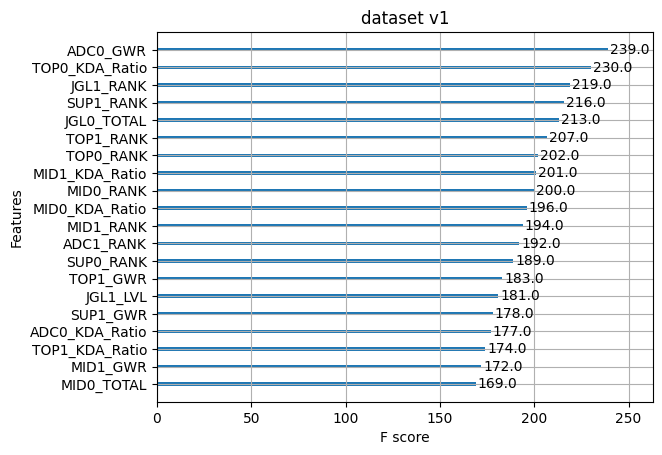

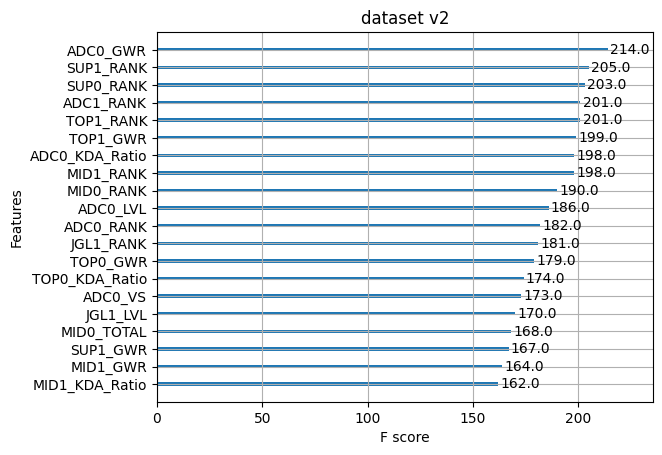

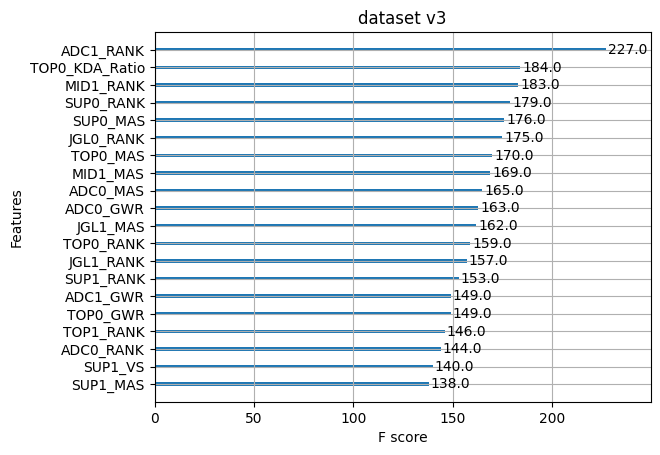

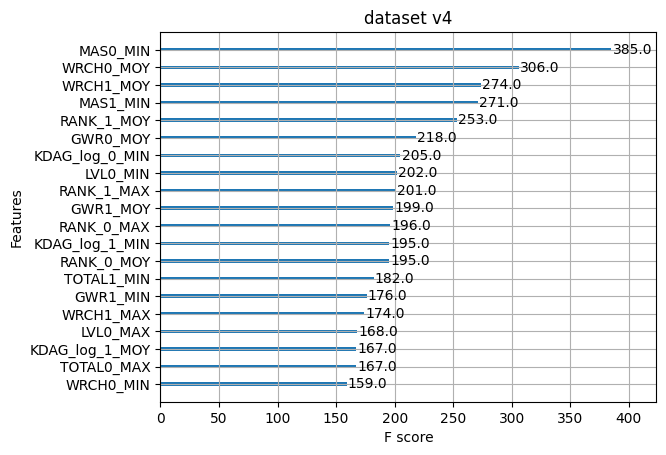

In [283]:
score_dataset = []
datasets_post_FE.append(dataset_v4)

for i in range(len(datasets_post_FE)):
    X = datasets_post_FE[i]
    y = Y[i]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1)

    xgb_best = xgb.XGBClassifier(n_estimators=300,learning_rate=0.05,n_jobs=-1)
    xgb_best.fit(X_train,y_train)
    xgb.plot_importance(xgb_best, title=f"dataset v{i+1}",max_num_features = 20)

    score_dataset.append(pourcentage_reussite(xgb_best.predict(X_test),y_test))

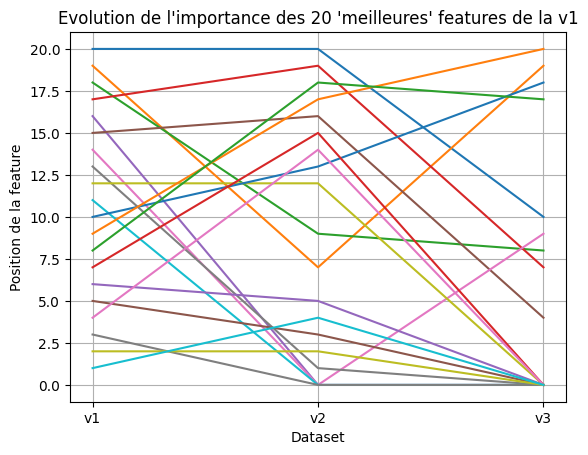

In [295]:
pos = [1,2,3]
plt.plot(pos,[20,20,10],label = "ADC0_GWR")
plt.plot(pos,[19,7,19],label = "TOP0_KDA_RATIO")
plt.plot(pos,[18,9,8],label = "JGL1_RANK")
plt.plot(pos,[17,19,7],label = "SUP1_RANK")
plt.plot(pos,[16,0,0],label = "JGL0_TOTAL")
plt.plot(pos,[15,16,4],label = "SUP0_TOTAL")
plt.plot(pos,[14,0,9],label = "TOP0_RANK")
plt.plot(pos,[13,1,0],label = "MID1_KDA_RATIO")
plt.plot(pos,[12,12,0],label = "MID0_RANK")
plt.plot(pos,[11,0,0],label = "MID0_KDA_RATIO")
plt.plot(pos,[10,13,18],label = "MID1_RANK")
plt.plot(pos,[9,17,20],label = "ADC0_RANK")
plt.plot(pos,[8,18,17],label = "SUP0_RANK")
plt.plot(pos,[7,15,0],label = "TOP1_GWR")
plt.plot(pos,[6,5,0],label = "TJGL1_LVL")
plt.plot(pos,[5,3,0],label = "SUP1_GWR")
plt.plot(pos,[4,14,0],label = "ADC0_KDA_RATIO")
plt.plot(pos,[3,0,0],label = "TOP1_KDA_RATIO")
plt.plot(pos,[2,2,0],label = "MID1_GWR")
plt.plot(pos,[1,4,0],label = "MID0_TOTAL")

labels = ["en dehors", "MID0_TOTAL","MID1_GWR","TOP1_KDA_RATIO","ADC0_KDA_RATIO","SUP1_GWR","TJGL1_LVL","TOP1_GWR","SUP0_RANK","ADC0_RANK","MID1_RANK","MID0_KDA_RATIO","MID0_RANK","MID1_KDA_RATIO"
            ,"TOP0_RANK","SUP0_TOTAL","JGL0_TOTAL","SUP1_RANK","JGL1_RANK","TOP0_KDA_RATIO","ADC0_GWR"]

plt.title("Evolution de l'importance des 20 'meilleures' features de la v1")
plt.xlabel("Dataset")
plt.ylabel("Position de la feature")
plt.xticks(pos,["v1","v2","v3"])
plt.yticks(np.arange(0,21),labels)

plt.grid(visible=True)

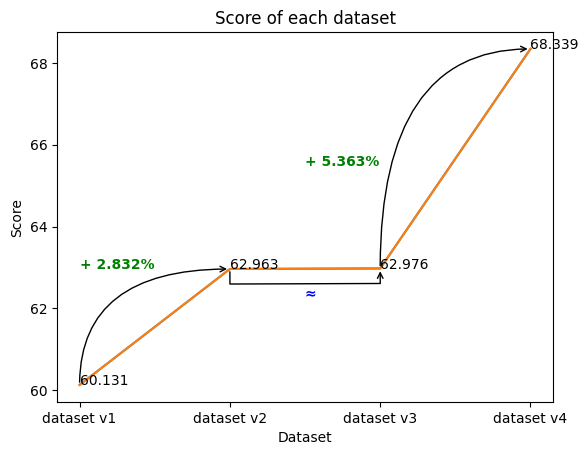

In [274]:
score_arrondi = [round(score,3) for score in score_dataset]

plt.plot([1,2,3,4],score_arrondi)
plt.plot([1,2,3,4],[score_arrondi[0],score_arrondi[1],score_arrondi[2],score_arrondi[3]])

for i in range(len(score_arrondi)):
    plt.text(i+1,score_arrondi[i],score_arrondi[i])

plt.title("Score of each dataset")
plt.xlabel("Dataset")
plt.xticks([1,2,3,4],['dataset v1','dataset v2','dataset v3','dataset v4'])
plt.ylabel("Score")

plt.annotate("", xy=(2, score_arrondi[1]), xytext=(1, score_arrondi[0]),
                arrowprops=dict(arrowstyle="->", connectionstyle="angle3,angleA=90,angleB=0"))

plt.annotate("", xy=(4, score_arrondi[3]), xytext=(3, score_arrondi[2]),
                arrowprops=dict(arrowstyle="->", connectionstyle="angle3,angleA=90,angleB=0"))

plt.annotate("", xy=(3, score_arrondi[2]), xytext=(2, score_arrondi[1]),
                arrowprops=dict(arrowstyle="->", connectionstyle="bar,fraction=0.1"))

plt.text(2.5, score_arrondi[2]+2.5, f"+ {round(score_arrondi[3]-score_arrondi[2],3)}%",fontweight='demibold',color='green')
plt.text(1, score_arrondi[1], f"+ {round(score_arrondi[1]-score_arrondi[0],3)}%",fontweight='demibold',color='green')
plt.text(2.5, score_arrondi[2]-0.7, f"≈",fontweight='demibold',color='blue')

plt.show()

> Rajouter à quoi correspondant précisement les colonnes rajoutées à chaque fois, ainsi que les changements opérés sur la v4, faire l'étude pour qq features de leur différence de places entre les dataset v1, v2 et v3